# Codebase for "A Dynamic Theory of Deterrence and Compliance"

Format: JupyterLab Notebook

Kernel: Python3

Code for all results and figures. 

*Note, to use this file user must first set the local path to store results of computation.*

In [13]:
""" 
    import libraries and set display options 
"""
import sys
import matplotlib.collections

import random as rn
import numpy as np
import math as math
import quantecon as qe
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

from numba import jit


#path_data = 
#path_code = 
#path_figs =

In [14]:
""" 
    baseline model parameters for kernel
    
"""
# main parameters
agents = 100
Z = 2

# distribution parameters
ḡ , σ = 0.6 , 0.2

# Bayesian priors
α, β = 1, 0.25

# costs
ρ, λ = 2 , 5

# domain of analysis for policy
F = 1
R_low, R_high = 0, agents+1

# benchmarking parameters
block = 50000
checks, C = 5, 0.01

In [15]:
""" 
    functions used by simulations 
"""
def acf(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
        for i in range(1, length)])

# apprehension function, min catch
@jit(nopython=True)
def Apprehend(v, R):
    γ = 0.80 
    if v == 0:
        prob_a = γ
    else:
        prob_a = γ*min(1, R/v)
    return prob_a

# create a distribution of 'criminal opportunities'
@jit(nopython=True)
def Criminal_opps(μ, σ, agents, T):
    g = np.zeros((T,agents))
    for i in range(T):
        g[i] = [max(0, np.random.normal(ḡ, σ)) for agent in range(agents)]
    return g

def Simulation(criminal_opps, R, F, Z):
# agent priors
    α,β = 1, 0.25
    init_period = 100
# tracking arrays for endogenous variables of interest
    a_t,v_t, g_t, q_t = [], [], [], []
# seed for priors
    append_v = v_t.append
    append_a = a_t.append
    append_g = g_t.append
    append_q = q_t.append
    for t in range(Z):
        v = np.random.randint(1,agents)
        a = np.random.randint(0,v)
        append_v(v)
        append_a(a)
# main sim loop, starts at T = 500   
    for t in range(len(criminal_opps)):
        a, v, g, q = 0, 0, 0, 0
        q = (α + np.sum(a_t[-Z:]))/(α + β + np.sum(v_t[-Z:]))
        for g_i in criminal_opps[t]:
            if  q <= g_i/F:
                v = v + 1
                g = g + g_i
        a = stats.binom.rvs(v, Apprehend(v, R))
        append_v(v)
        append_a(a)
        append_g(g)
        append_q(q)
    
    return np.array(v_t[init_period+Z:]), np.array(a_t[init_period+Z:]), np.array(g_t[init_period+Z:]), np.array(q_t[init_period+Z:])

def equilibrium_sim_pareto(ḡ, σ, R, agents, runs):
    pareto_equilibria = np.zeros(runs)
    for run in range(0,runs):
        equilibria = []
        G = -np.sort(-Criminal_opps(ḡ,σ,agents,1))
        for v in range(agents+1):
            if len([i for i in G[0] if i >= Apprehend(v,R)]) == v:
                if len([i for i in G[0] if i >= Apprehend(v+1,R)]) == v:
                    equilibria.append(v)
        pareto_equilibria[run] = min(equilibria)

    return pareto_equilibria

def equilibrium_sim_random(ḡ, σ, R, agents, runs):
    random_equilibria = np.zeros(runs)
    for run in range(0,runs):
        equilibria = []
        G = -np.sort(-Criminal_opps(ḡ,σ,agents,1))
        for v in range(agents+1):
            if len([i for i in G[0] if i >= Apprehend(v,R)]) == v:
                if len([i for i in G[0] if i >= Apprehend(v+1,R)]) == v:
                    equilibria.append(v)
        random_equilibria[run] = rn.choice(equilibria)

    return random_equilibria  


## Figure 4.1: Simulated time series of violations for chosen values of R, D-model

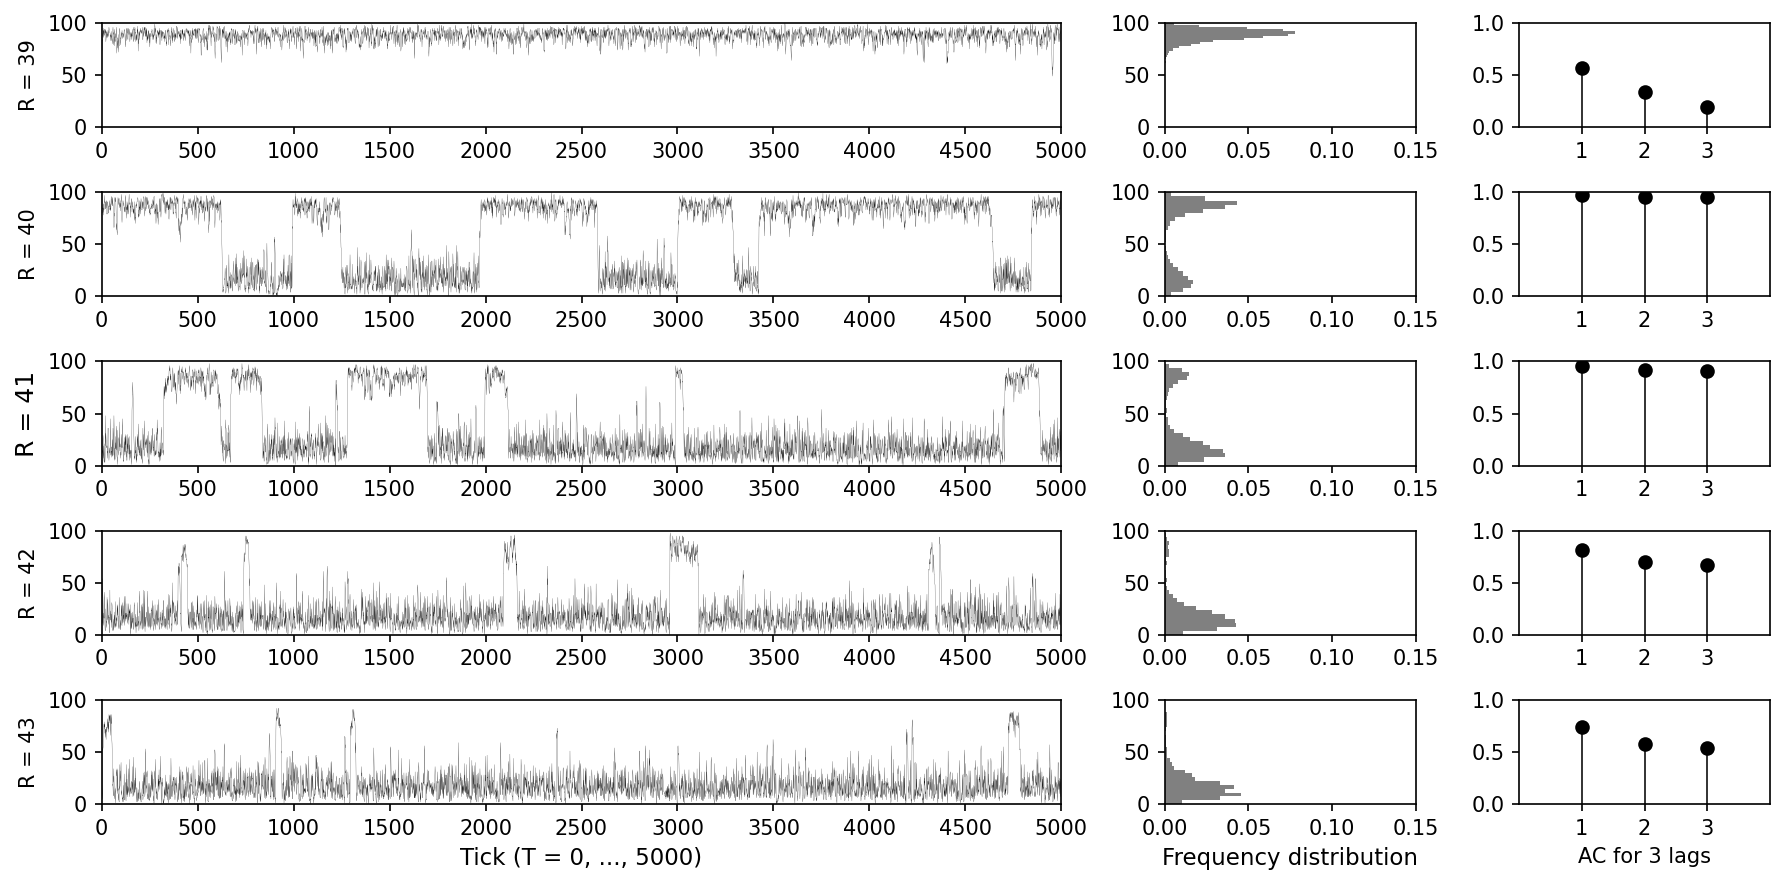

In [16]:
"""
        Fig 4.1: time path of 'raw data'
            Note: Set T = block for plotting purposes
"""

fig = plt.figure(figsize=(12,6),tight_layout=True,dpi=150)
gs = fig.add_gridspec(5, 5)
ax1 = fig.add_subplot(gs[0, :3])
iax1 = fig.add_subplot(gs[0, 3:4])
iax11 = fig.add_subplot(gs[0, 4:5])

ax2 = fig.add_subplot(gs[1, :3])
iax2 = fig.add_subplot(gs[1, 3:4])
iax22 = fig.add_subplot(gs[1, 4:5])

ax3 = fig.add_subplot(gs[2, :3])
iax3 = fig.add_subplot(gs[2, 3:4])
iax33 = fig.add_subplot(gs[2, 4:5])

ax4 = fig.add_subplot(gs[3, :3])
iax4 = fig.add_subplot(gs[3, 3:4])
iax44 = fig.add_subplot(gs[3, 4:5])

ax5 = fig.add_subplot(gs[4, :3])
iax5 = fig.add_subplot(gs[4, 3:4])
iax55 = fig.add_subplot(gs[4, 4:5])

illustrative_run = Criminal_opps(ḡ, σ, agents, 6000)
v, a, g, q = Simulation(illustrative_run,39,F,Z)
ax1.set_xlim([0, 5000])
ax1.set_ylim([0, agents])
ax1.set_xticks(np.arange(0, 5000+250, 500))
ax1.set(ylabel='R = 39')
ax1.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax1.set_xlim([0, 0.15])
iax1.set_ylim([0,agents])
iax1.set_xticks(np.arange(0,0.20,0.05))
iax1.yaxis.label.set_size(10)
iax1.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)
iax11.set_xlim([0, 4])
iax11.set_ylim([0,1])
iax11.set_xticks(np.arange(1,4,1))
iax11.yaxis.label.set_size(10)
iax11.vlines(1, ymin=0, ymax=acf(v)[1], color ='k', linestyle='solid',linewidth=0.75)
iax11.vlines(2, ymin=0, ymax=acf(v)[2], color ='k', linestyle='solid',linewidth=0.75)
iax11.vlines(3, ymin=0, ymax=acf(v)[3], color ='k', linestyle='solid',linewidth=0.75)
iax11.scatter([1,2,3], acf(v)[1:4], facecolors='black', edgecolors='black')

illustrative_run = Criminal_opps(ḡ, σ, agents, 6000)
v, a, g, q = Simulation(illustrative_run,40,F,Z)
ax2.set(ylabel='R = 40')
ax2.set_xlim([0, 5000])
ax2.set_ylim([0, agents])
ax2.set_xticks(np.arange(0, 5000+500, 500))
ax2.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax2.set_xlim([0, 0.15])
iax2.set_ylim([0,agents])
iax2.set_xticks(np.arange(0,0.20,0.05))
iax2.yaxis.label.set_size(10)
iax2.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)
iax22.set_xlim([0, 4])
iax22.set_ylim([0,1])
iax22.set_xticks(np.arange(1,4,1))
iax22.yaxis.label.set_size(10)
iax22.vlines(1, ymin=0, ymax=acf(v)[1], color ='k', linestyle='solid',linewidth=0.75)
iax22.vlines(2, ymin=0, ymax=acf(v)[2], color ='k', linestyle='solid',linewidth=0.75)
iax22.vlines(3, ymin=0, ymax=acf(v)[3], color ='k', linestyle='solid',linewidth=0.75)
iax22.scatter([1,2,3], acf(v)[1:4], facecolors='black', edgecolors='black')

illustrative_run = Criminal_opps(ḡ, σ, agents, 6000)
v, a, g, q = Simulation(illustrative_run,41,F,Z)
ax3.set(ylabel='R = 41')
ax3.yaxis.label.set_size(12)
ax3.set_xlim([0, 5000])
ax3.set_ylim([0, agents])
ax3.set_xticks(np.arange(0, 5000+250, 500))
ax3.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax3.set_xlim([0, 0.15])
iax3.set_ylim([0,agents])
iax3.set_xticks(np.arange(0,0.20,0.05))
iax3.yaxis.label.set_size(10)
iax3.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)
iax33.set_xlim([0, 4])
iax33.set_ylim([0,1])
iax33.set_xticks(np.arange(1,4,1))
iax33.yaxis.label.set_size(10)
iax33.vlines(1, ymin=0, ymax=acf(v)[1], color ='k', linestyle='solid',linewidth=0.75)
iax33.vlines(2, ymin=0, ymax=acf(v)[2], color ='k', linestyle='solid',linewidth=0.75)
iax33.vlines(3, ymin=0, ymax=acf(v)[3], color ='k', linestyle='solid',linewidth=0.75)
iax33.scatter([1,2,3], acf(v)[1:4], facecolors='black', edgecolors='black')

illustrative_run = Criminal_opps(ḡ, σ, agents, 6000)
v, a, g, q = Simulation(illustrative_run,42,F,Z)
ax4.set(ylabel='R = 42')
ax4.set_xlim([0, 5000])
ax4.set_ylim([0, agents])
ax4.set_xticks(np.arange(0, 5000+250, 500))
ax4.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax4.set_xlim([0, 0.15])
iax4.set_ylim([0,agents])
iax4.set_xticks(np.arange(0,0.20,0.05))
iax4.yaxis.label.set_size(10)
iax4.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)
iax44.set_xlim([0, 4])
iax44.set_ylim([0,1])
iax44.set_xticks(np.arange(1,4,1))
iax44.yaxis.label.set_size(10)
iax44.vlines(1, ymin=0, ymax=acf(v)[1], color ='k', linestyle='solid',linewidth=0.75)
iax44.vlines(2, ymin=0, ymax=acf(v)[2], color ='k', linestyle='solid',linewidth=0.75)
iax44.vlines(3, ymin=0, ymax=acf(v)[3], color ='k', linestyle='solid',linewidth=0.75)
iax44.scatter([1,2,3], acf(v)[1:4], facecolors='black', edgecolors='black')

illustrative_run = Criminal_opps(ḡ, σ, agents, 6000)
v, a, g, q = Simulation(illustrative_run,43,F,Z)
ax5.set(ylabel='R = 43')
ax5.set(xlabel='Tick (T = 0, ..., 5000)')
ax5.xaxis.label.set_size(11)
ax5.set_xlim([0, 5000])
ax5.set_ylim([0, agents])
ax5.set_xticks(np.arange(0, 5000+250, 500))
ax5.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax5.set_xlim([0, 0.15])
iax5.set_ylim([0,agents])
iax5.yaxis.label.set_size(10)
iax5.set_xticks(np.arange(0,0.20,0.05))
iax5.set(xlabel='Frequency distribution')
iax5.xaxis.label.set_size(11)
iax5.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)
iax55.set_xlim([0, 4])
iax55.set_ylim([0,1])
iax55.set_xticks(np.arange(1,4,1))
iax55.yaxis.label.set_size(11)
iax55.set(xlabel='AC for 3 lags')
iax55.vlines(1, ymin=0, ymax=acf(v)[1], color ='k', linestyle='solid',linewidth=0.75)
iax55.vlines(2, ymin=0, ymax=acf(v)[2], color ='k', linestyle='solid',linewidth=0.75)
iax55.vlines(3, ymin=0, ymax=acf(v)[3], color ='k', linestyle='solid',linewidth=0.75)
iax55.scatter([1,2,3], acf(v)[1:4], facecolors='black', edgecolors='black')

#plt.savefig();

## Figure 4.3: Simulated time series of violations for chosen values of R, R-model

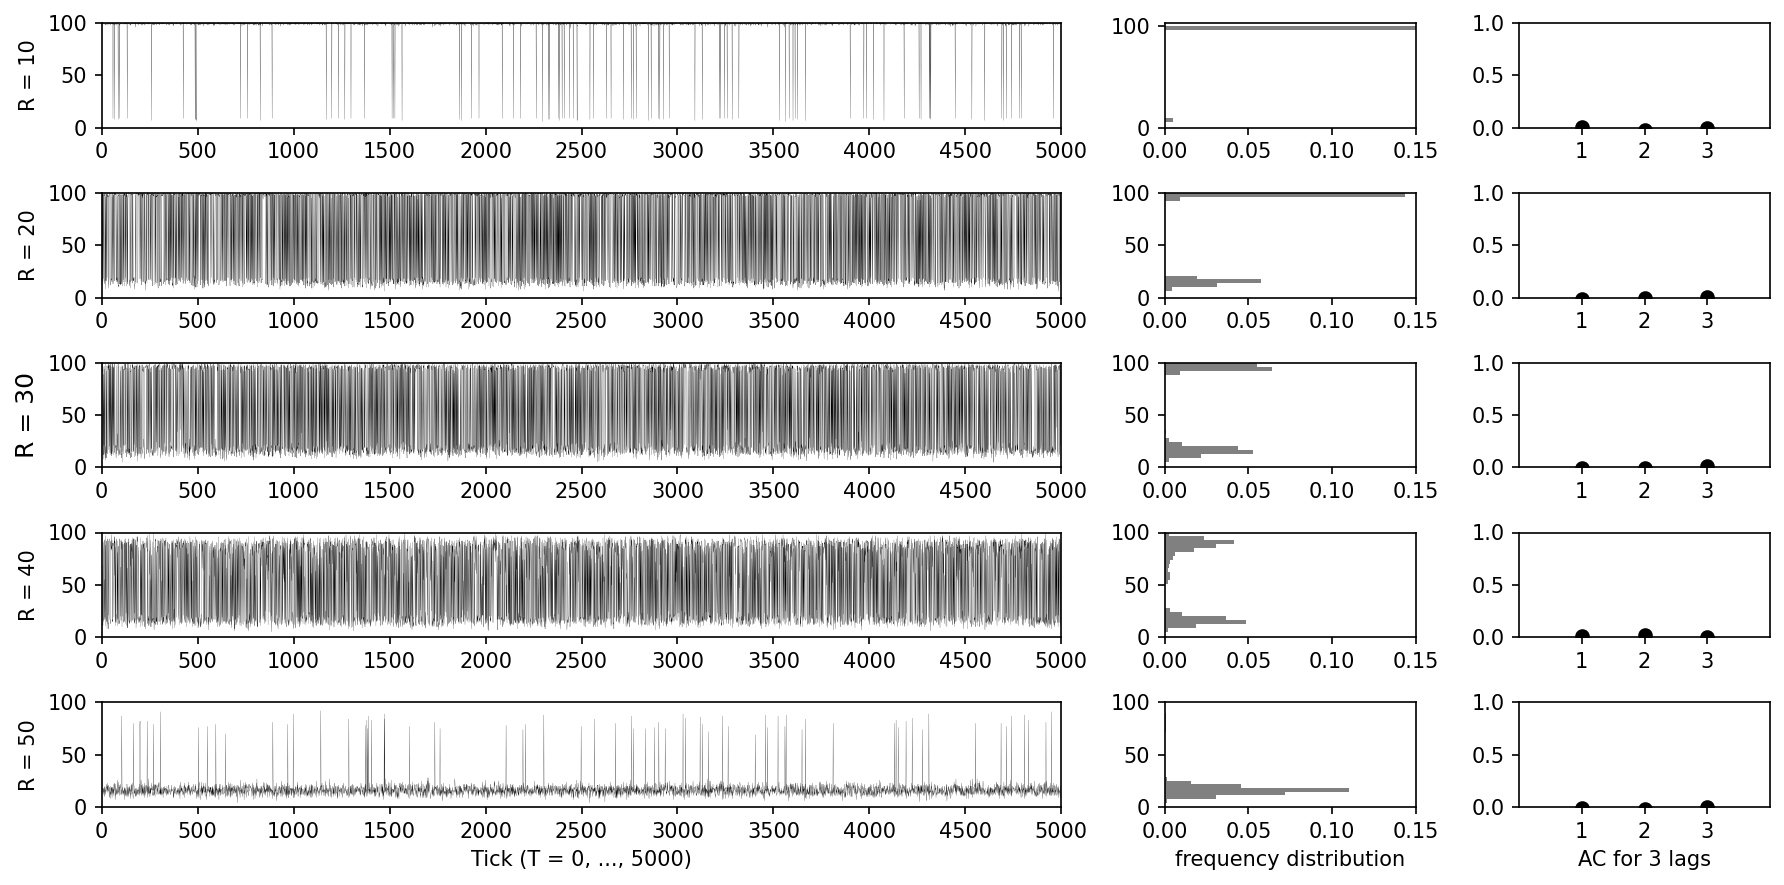

In [17]:
"""
        Fig 4.3: time path of 'raw data'
            Note: Set T = block for plotting purposes
"""

fig = plt.figure(figsize=(12,6),tight_layout=True,dpi=150)
gs = fig.add_gridspec(5, 5)
ax1 = fig.add_subplot(gs[0, :3])
iax1 = fig.add_subplot(gs[0, 3:4])
iax11 = fig.add_subplot(gs[0, 4:5])

ax2 = fig.add_subplot(gs[1, :3])
iax2 = fig.add_subplot(gs[1, 3:4])
iax22 = fig.add_subplot(gs[1, 4:5])

ax3 = fig.add_subplot(gs[2, :3])
iax3 = fig.add_subplot(gs[2, 3:4])
iax33 = fig.add_subplot(gs[2, 4:5])

ax4 = fig.add_subplot(gs[3, :3])
iax4 = fig.add_subplot(gs[3, 3:4])
iax44 = fig.add_subplot(gs[3, 4:5])

ax5 = fig.add_subplot(gs[4, :3])
iax5 = fig.add_subplot(gs[4, 3:4])
iax55 = fig.add_subplot(gs[4, 4:5])

v = equilibrium_sim_random(ḡ, σ, 10, agents, 6000)
ax1.set_xlim([0, 5000])
ax1.set_ylim([0, agents])
ax1.set_xticks(np.arange(0, 5000+250, 500))
ax1.set(ylabel='R = 10')
ax1.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax1.set_xlim([0, 0.15])
iax1.set_ylim([0,agents+3])
iax1.set_xticks(np.arange(0,0.20,0.05))
iax1.yaxis.label.set_size(10)
iax1.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)
iax11.set_xlim([0, 4])
iax11.set_ylim([0,1])
iax11.set_xticks(np.arange(1,4,1))
iax11.yaxis.label.set_size(10)
iax11.vlines(1, ymin=0, ymax=acf(v)[1], color ='k', linestyle='solid',linewidth=0.75)
iax11.vlines(2, ymin=0, ymax=acf(v)[2], color ='k', linestyle='solid',linewidth=0.75)
iax11.vlines(3, ymin=0, ymax=acf(v)[3], color ='k', linestyle='solid',linewidth=0.75)
iax11.scatter([1,2,3], acf(v)[1:4], facecolors='black', edgecolors='black')

v = equilibrium_sim_random(ḡ, σ, 20, agents, 6000)
ax2.set(ylabel='R = 20')
ax2.set_xlim([0, 5000])
ax2.set_ylim([0, agents])
ax2.set_xticks(np.arange(0, 5000+500, 500))
ax2.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax2.set_xlim([0, 0.15])
iax2.set_ylim([0,agents])
iax2.set_xticks(np.arange(0,0.20,0.05))
iax2.yaxis.label.set_size(10)
iax2.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)
iax22.set_xlim([0, 4])
iax22.set_ylim([0,1])
iax22.set_xticks(np.arange(1,4,1))
iax22.yaxis.label.set_size(10)
iax22.vlines(1, ymin=0, ymax=acf(v)[1], color ='k', linestyle='solid',linewidth=0.75)
iax22.vlines(2, ymin=0, ymax=acf(v)[2], color ='k', linestyle='solid',linewidth=0.75)
iax22.vlines(3, ymin=0, ymax=acf(v)[3], color ='k', linestyle='solid',linewidth=0.75)
iax22.scatter([1,2,3], acf(v)[1:4], facecolors='black', edgecolors='black')

v = equilibrium_sim_random(ḡ, σ, 30, agents, 6000)
ax3.set(ylabel='R = 30')
ax3.yaxis.label.set_size(12)
ax3.set_xlim([0, 5000])
ax3.set_ylim([0, agents])
ax3.set_xticks(np.arange(0, 5000+250, 500))
ax3.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax3.set_xlim([0, 0.15])
iax3.set_ylim([0,agents])
iax3.set_xticks(np.arange(0,0.20,0.05))
iax3.yaxis.label.set_size(10)
iax3.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)
iax33.set_xlim([0, 4])
iax33.set_ylim([0,1])
iax33.set_xticks(np.arange(1,4,1))
iax33.yaxis.label.set_size(10)
iax33.vlines(1, ymin=0, ymax=acf(v)[1], color ='k', linestyle='solid',linewidth=0.75)
iax33.vlines(2, ymin=0, ymax=acf(v)[2], color ='k', linestyle='solid',linewidth=0.75)
iax33.vlines(3, ymin=0, ymax=acf(v)[3], color ='k', linestyle='solid',linewidth=0.75)
iax33.scatter([1,2,3], acf(v)[1:4], facecolors='black', edgecolors='black')

v = equilibrium_sim_random(ḡ, σ, 40, agents, 6000)
ax4.set(ylabel='R = 40')
ax4.set_xlim([0, 5000])
ax4.set_ylim([0, agents])
ax4.set_xticks(np.arange(0, 5000+250, 500))
ax4.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax4.set_xlim([0, 0.15])
iax4.set_ylim([0,agents])
iax4.set_xticks(np.arange(0,0.20,0.05))
iax4.yaxis.label.set_size(10)
iax4.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)
iax44.set_xlim([0, 4])
iax44.set_ylim([0,1])
iax44.set_xticks(np.arange(1,4,1))
iax44.yaxis.label.set_size(10)
iax44.vlines(1, ymin=0, ymax=acf(v)[1], color ='k', linestyle='solid',linewidth=0.75)
iax44.vlines(2, ymin=0, ymax=acf(v)[2], color ='k', linestyle='solid',linewidth=0.75)
iax44.vlines(3, ymin=0, ymax=acf(v)[3], color ='k', linestyle='solid',linewidth=0.75)
iax44.scatter([1,2,3], acf(v)[1:4], facecolors='black', edgecolors='black')

v = equilibrium_sim_random(ḡ, σ, 50, agents, 6000)
ax5.set(ylabel='R = 50')
ax5.set(xlabel='Tick (T = 0, ..., 5000)')
ax5.xaxis.label.set_size(10)
ax5.set_xlim([0, 5000])
ax5.set_ylim([0, agents])
ax5.set_xticks(np.arange(0, 5000+250, 500))
ax5.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax5.set_xlim([0, 0.15])
iax5.set_ylim([0,agents])
iax5.yaxis.label.set_size(10)
iax5.set_xticks(np.arange(0,0.20,0.05))
iax5.set(xlabel='frequency distribution')
iax5.xaxis.label.set_size(10)
iax5.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)
iax55.set_xlim([0, 4])
iax55.set_ylim([0,1])
iax55.set_xticks(np.arange(1,4,1))
iax55.yaxis.label.set_size(10)
iax55.set(xlabel='AC for 3 lags')
iax55.vlines(1, ymin=0, ymax=acf(v)[1], color ='k', linestyle='solid',linewidth=0.75)
iax55.vlines(2, ymin=0, ymax=acf(v)[2], color ='k', linestyle='solid',linewidth=0.75)
iax55.vlines(3, ymin=0, ymax=acf(v)[3], color ='k', linestyle='solid',linewidth=0.75)
iax55.scatter([1,2,3], acf(v)[1:4], facecolors='black', edgecolors='black')

#plt.savefig();

## Figure 4.4: Simulated time series of violations for chosen values of R, P-model.

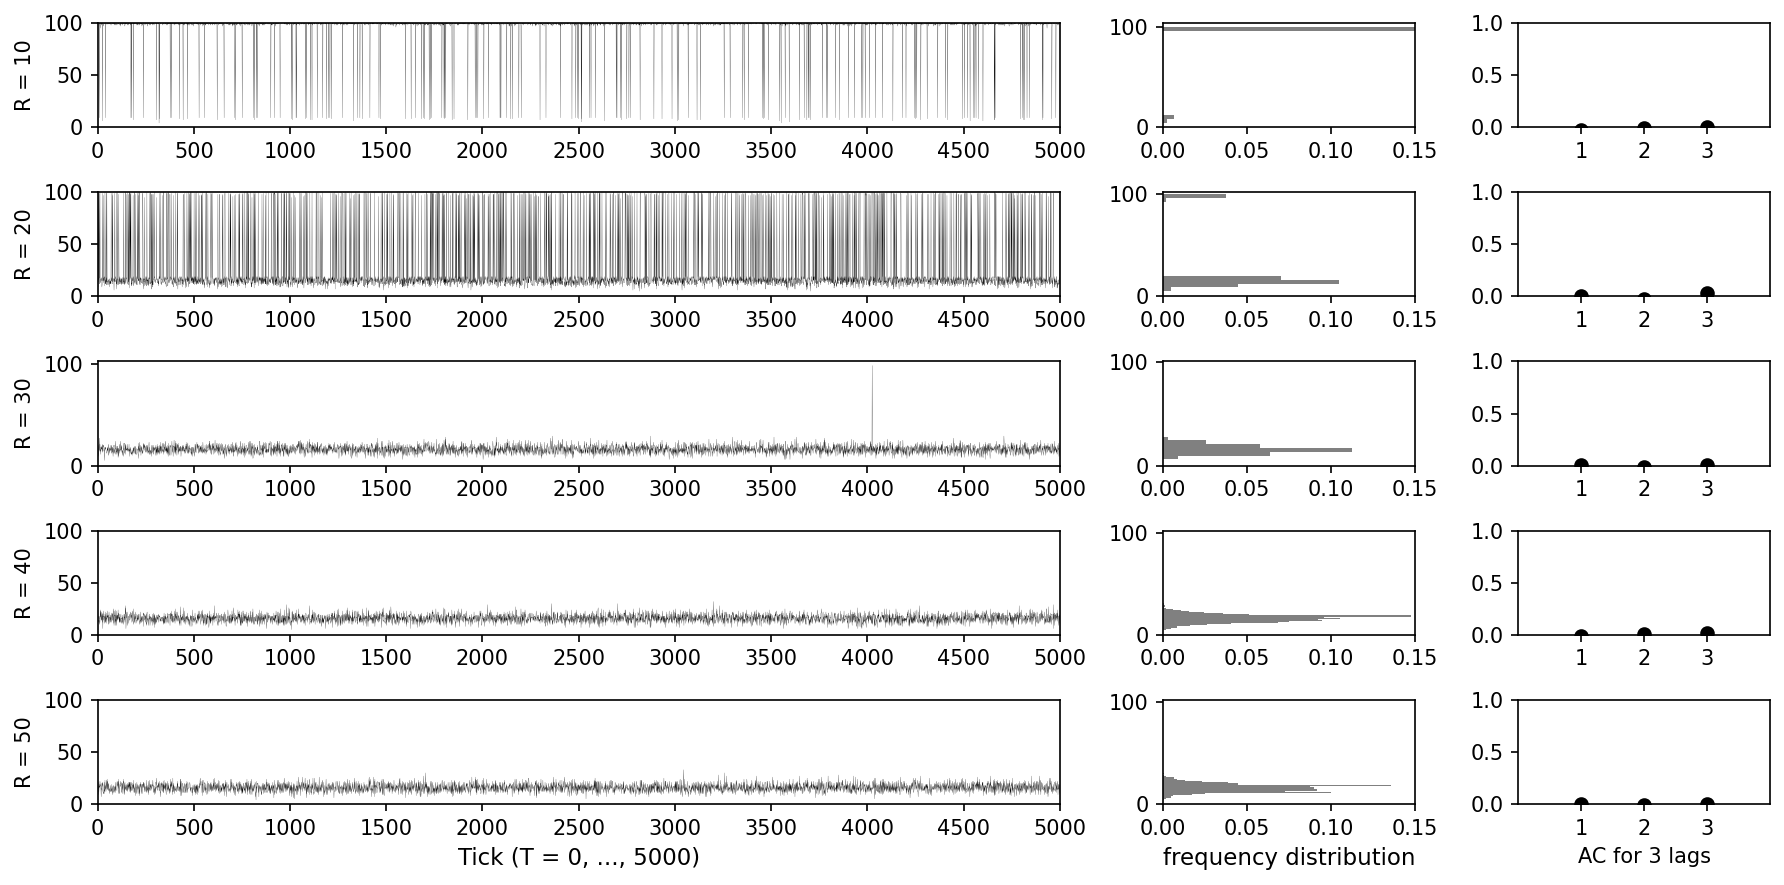

In [19]:
"""
        Fig 4.4: time path of 'raw data'
            Note: Set T = block for plotting purposes
"""

fig = plt.figure(figsize=(12,6),tight_layout=True,dpi=150)
gs = fig.add_gridspec(5, 5)
ax1 = fig.add_subplot(gs[0, :3])
iax1 = fig.add_subplot(gs[0, 3:4])
iax11 = fig.add_subplot(gs[0, 4:5])

ax2 = fig.add_subplot(gs[1, :3])
iax2 = fig.add_subplot(gs[1, 3:4])
iax22 = fig.add_subplot(gs[1, 4:5])

ax3 = fig.add_subplot(gs[2, :3])
iax3 = fig.add_subplot(gs[2, 3:4])
iax33 = fig.add_subplot(gs[2, 4:5])

ax4 = fig.add_subplot(gs[3, :3])
iax4 = fig.add_subplot(gs[3, 3:4])
iax44 = fig.add_subplot(gs[3, 4:5])

ax5 = fig.add_subplot(gs[4, :3])
iax5 = fig.add_subplot(gs[4, 3:4])
iax55 = fig.add_subplot(gs[4, 4:5])

v = equilibrium_sim_pareto(ḡ, σ, 10, agents, 6000)
ax1.set_xlim([0, 5000])
ax1.set_ylim([0, agents])
ax1.set_xticks(np.arange(0, 5000+250, 500))
ax1.set(ylabel='R = 10')
ax1.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax1.set_xlim([0, 0.15])
iax1.set_ylim([0,agents+4])
iax1.set_xticks(np.arange(0,0.20,0.05))
iax1.yaxis.label.set_size(10)
iax1.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)
iax11.set_xlim([0, 4])
iax11.set_ylim([0,1])
iax11.set_xticks(np.arange(1,4,1))
iax11.yaxis.label.set_size(10)
iax11.vlines(1, ymin=0, ymax=acf(v)[1], color ='k', linestyle='solid',linewidth=0.75)
iax11.vlines(2, ymin=0, ymax=acf(v)[2], color ='k', linestyle='solid',linewidth=0.75)
iax11.vlines(3, ymin=0, ymax=acf(v)[3], color ='k', linestyle='solid',linewidth=0.75)
iax11.scatter([1,2,3], acf(v)[1:4], facecolors='black', edgecolors='black')

v = equilibrium_sim_pareto(ḡ, σ, 20, agents, 6000)
ax2.set(ylabel='R = 20')
ax2.set_xlim([0, 5000])
ax2.set_ylim([0, agents])
ax2.set_xticks(np.arange(0, 5000+500, 500))
ax2.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax2.set_xlim([0, 0.15])
iax2.set_ylim([0,agents+2])
iax2.set_xticks(np.arange(0,0.20,0.05))
iax2.yaxis.label.set_size(10)
iax2.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)
iax22.set_xlim([0, 4])
iax22.set_ylim([0,1])
iax22.set_xticks(np.arange(1,4,1))
iax22.yaxis.label.set_size(10)
iax22.vlines(1, ymin=0, ymax=acf(v)[1], color ='k', linestyle='solid',linewidth=0.75)
iax22.vlines(2, ymin=0, ymax=acf(v)[2], color ='k', linestyle='solid',linewidth=0.75)
iax22.vlines(3, ymin=0, ymax=acf(v)[3], color ='k', linestyle='solid',linewidth=0.75)
iax22.scatter([1,2,3], acf(v)[1:4], facecolors='black', edgecolors='black')

v = equilibrium_sim_pareto(ḡ, σ, 30, agents, 6000)
ax3.set(ylabel='R = 30')
ax3.yaxis.label.set_size(10)
ax3.set_xlim([0, 5000])
ax3.set_ylim([0, agents+2])
ax3.set_xticks(np.arange(0, 5000+250, 500))
ax3.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax3.set_xlim([0, 0.15])
iax3.set_ylim([0,agents+1])
iax3.set_xticks(np.arange(0,0.20,0.05))
iax3.yaxis.label.set_size(10)
iax3.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)
iax33.set_xlim([0, 4])
iax33.set_ylim([0,1])
iax33.set_xticks(np.arange(1,4,1))
iax33.yaxis.label.set_size(10)
iax33.vlines(1, ymin=0, ymax=acf(v)[1], color ='k', linestyle='solid',linewidth=0.75)
iax33.vlines(2, ymin=0, ymax=acf(v)[2], color ='k', linestyle='solid',linewidth=0.75)
iax33.vlines(3, ymin=0, ymax=acf(v)[3], color ='k', linestyle='solid',linewidth=0.75)
iax33.scatter([1,2,3], acf(v)[1:4], facecolors='black', edgecolors='black')

v = equilibrium_sim_pareto(ḡ, σ, 40, agents, 6000)
ax4.set(ylabel='R = 40')
ax4.set_xlim([0, 5000])
ax4.set_ylim([0, agents])
ax4.set_xticks(np.arange(0, 5000+250, 500))
ax4.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax4.set_xlim([0, 0.15])
iax4.set_ylim([0,agents+2])
iax4.set_xticks(np.arange(0,0.20,0.05))
iax4.yaxis.label.set_size(10)
iax4.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)
iax44.set_xlim([0, 4])
iax44.set_ylim([0,1])
iax44.set_xticks(np.arange(1,4,1))
iax44.yaxis.label.set_size(10)
iax44.vlines(1, ymin=0, ymax=acf(v)[1], color ='k', linestyle='solid',linewidth=0.75)
iax44.vlines(2, ymin=0, ymax=acf(v)[2], color ='k', linestyle='solid',linewidth=0.75)
iax44.vlines(3, ymin=0, ymax=acf(v)[3], color ='k', linestyle='solid',linewidth=0.75)
iax44.scatter([1,2,3], acf(v)[1:4], facecolors='black', edgecolors='black')

v = equilibrium_sim_pareto(ḡ, σ, 50, agents, 6000)
ax5.set(ylabel='R = 50')
ax5.set(xlabel='Tick (T = 0, ..., 5000)')
ax5.xaxis.label.set_size(11)
ax5.set_xlim([0, 5000])
ax5.set_ylim([0, agents])
ax5.set_xticks(np.arange(0, 5000+250, 500))
ax5.plot(v[500:6000],color='k',linewidth=0.10, label="violations")
plt.xticks(np.arange(0, agents))
plt.xlim(0,agents)
iax5.set_xlim([0, 0.15])
iax5.set_ylim([0,agents+2])
iax5.yaxis.label.set_size(12)
iax5.set_xticks(np.arange(0,0.20,0.05))
iax5.set(xlabel='frequency distribution')
iax5.xaxis.label.set_size(11)
iax5.hist(v[1000:6000], color='gray', orientation ='horizontal', density=True, lw=0, bins=25)
iax55.set_xlim([0, 4])
iax55.set_ylim([0,1])
iax55.set_xticks(np.arange(1,4,1))
iax55.yaxis.label.set_size(12)
iax55.set(xlabel='AC for 3 lags')
iax55.vlines(1, ymin=0, ymax=acf(v)[1], color ='k', linestyle='solid',linewidth=0.75)
iax55.vlines(2, ymin=0, ymax=acf(v)[2], color ='k', linestyle='solid',linewidth=0.75)
iax55.vlines(3, ymin=0, ymax=acf(v)[3], color ='k', linestyle='solid',linewidth=0.75)
iax55.scatter([1,2,3], acf(v)[1:4], facecolors='black', edgecolors='black')

#plt.savefig();